In [1]:
import glob
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
#import pyfftw
import re

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter

%load_ext autoreload
%autoreload 2

2024-10-02 08:08:07.206671: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-02 08:08:07.439845: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 08:08:07.439884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 08:08:07.462237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 08:08:07.537858: I tensorflow/core/platform/cpu_feature_guar

In [2]:
save_plots = False
plot_dir = '../plots/plots_2024-09-20'

## Load and prep emu

In [3]:
# need to modify this on hyperion
dir_emus_lbias = '/home/kstoreyf/external'
emu, emu_bounds, emu_param_names = utils.load_emu(dir_emus_lbias=dir_emus_lbias)
emu_bounds_dict = dict(zip(emu_param_names, emu_bounds))

Loading l-bias lpt emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using ver

Nonlinear l-bias emulator loaded in memory.


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Load lib and p(k)s

In [22]:
# order of saved cosmo param files
# param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
# param_names = ['omega_cold', 'sigma_8', 'h']
# param_names_fixed = [name for name in param_names_all if name not in param_names]
# idxs_param_names = [param_names_all.index(name) for name in param_names]

n_grid = 128
n_grid_orig = 512
box_size = 1000.0

#tag_params = '_p3_n500'
tag_params = '_p5_n10000'
tag_mocks = tag_params
tag_fields = '_deconvolved'
#dir_mocks = f'/cosmos_storage/cosmosims/muchisimocks_lib{tag_mocks}'
#dir_mocks = f'/data/kstoreyf/muchisimocks/muchisimocks_lib{tag_mocks}'
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib{tag_mocks}'

title_tag = ', b=[0,0,0,0]'
tag_pk = '_b0000'
tag_pk_zspace = '_b0000_zspace'
dir_pks = f'../data/pks_mlib/pks{tag_mocks}{tag_pk}'
dir_pks_zspace = f'../data/pks_mlib/pks{tag_mocks}{tag_pk_zspace}'
bias_params = np.loadtxt(f'{dir_pks}/bias_params.txt')

fn_params = f'{dir_mocks}/params_lh{tag_params}.txt'
fn_params_fixed = f'{dir_mocks}/params_fixed{tag_params}.txt'
params_df = pd.read_csv(fn_params, index_col=0)
param_dict_fixed = pd.read_csv(fn_params_fixed).loc[0].to_dict()


idxs_LH_all = np.array([idx_LH for idx_LH in params_df.index.values 
                        if os.path.exists(f"{dir_pks}/pk_{idx_LH}.npy")
                        and os.path.exists(f"{dir_pks_zspace}/pk_{idx_LH}.npy")])
idxs_LH_all = np.sort(idxs_LH_all)
idxs_LH = idxs_LH_all
idxs_LH = np.array(np.sort(idxs_LH))
n_lib = len(idxs_LH)

print(n_lib)

10000


In [23]:
n_plot = 100
rng = np.random.default_rng(42)
i_plot = rng.choice(np.arange(len(idxs_LH)), n_plot, replace=False)
i_plot = np.array(np.sort(i_plot))

### Load data 

In [24]:
theta = []
Pk = []
Pk_zspace = []
gaussian_error_pk = []
gaussian_error_pk_zspace = []

param_names = params_df.columns.to_list()

for idx_LH in idxs_LH:
    #fn_fields = f'{dir_mocks}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
    #fn_params = f'{dir_mocks}/LH{idx_LH}/cosmo_{idx_LH}.txt'
    fn_pk = f'{dir_pks}/pk_{idx_LH}.npy'
    fn_pk_zspace = f'{dir_pks_zspace}/pk_{idx_LH}.npy'
    
    pk_obj = np.load(fn_pk, allow_pickle=True).item()
    Pk.append(pk_obj['pk'])
    gaussian_error_pk.append(pk_obj['pk_gaussian_error'])
    
    pk_obj_zspace = np.load(fn_pk_zspace, allow_pickle=True).item()
    Pk_zspace.append(pk_obj_zspace['pk'])
    gaussian_error_pk_zspace.append(pk_obj_zspace['pk_gaussian_error'])
    
    param_dict = params_df.loc[idx_LH].to_dict()
    theta.append( np.array([param_dict[pn] for pn in param_names]) )

Pk = np.array(Pk)
Pk_zspace = np.array(Pk_zspace)
theta = np.array(theta)
gaussian_error_pk = np.array(gaussian_error_pk)

kk = pk_obj['k'] # all ks should be same so just grab one
print(len(kk))
print(Pk.shape)

30
(10000, 30)


In [25]:
Pk_emu = []
dir_pnns = f'../data/pnns_mlib/pnns{tag_mocks}'
for i, idx_LH in enumerate(idxs_LH):
    fn_pnn = f'{dir_pnns}/pnn_{idx_LH}.npy'
    pnn_dict = np.load(fn_pnn, allow_pickle=True).item()
    pnn = pnn_dict['pnn']
    pk_emu, _ = utils.pnn_to_pk(pnn, bias_params)
    Pk_emu.append(pk_emu)

In [26]:
tag_b1 = f'_b{int(bias_params[0])}'
fn_kaiser = f'{dir_mocks}/kaiser_boosts{tag_params}{tag_b1}.csv'
df_kaiser = pd.read_csv(fn_kaiser, index_col=0)
kaiser_boosts = [df_kaiser.loc[idx_LH, 'kaiser_boost'] for idx_LH in idxs_LH]

In [27]:
kaiser_boosts = np.array(kaiser_boosts)
Pk_emu_zspace = Pk_emu * kaiser_boosts[:, np.newaxis] 
Pk_kaiserboosted = Pk * kaiser_boosts[:, np.newaxis] 

## Plot

/tmp/ipykernel_3333928/70976760.py:39: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(k, (Pk_emu[i]-Pk[i])/gaussian_error_pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_3333928/70976760.py:40: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (Pk_emu[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_3333928/70976760.py:46: RuntimeWarning: divide by zero encountered in divide
  diff_overG = diff_Pk/gaussian_error_pk
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_3333928/70976760.py:51: RuntimeWarning: divide by zero encountered in divide
  diff_overPk = diff_Pk/Pk


[<matplotlib.lines.Line2D object at 0x7f3e585a3e90>, <ErrorbarContainer object of 3 artists>] ['emulated at true $\\theta$', 'map2map measured']
[<matplotlib.lines.Line2D object at 0x7f3e7859b310>, <matplotlib.lines.Line2D object at 0x7f3e78598d50>] ['median', '16-84 percentile']


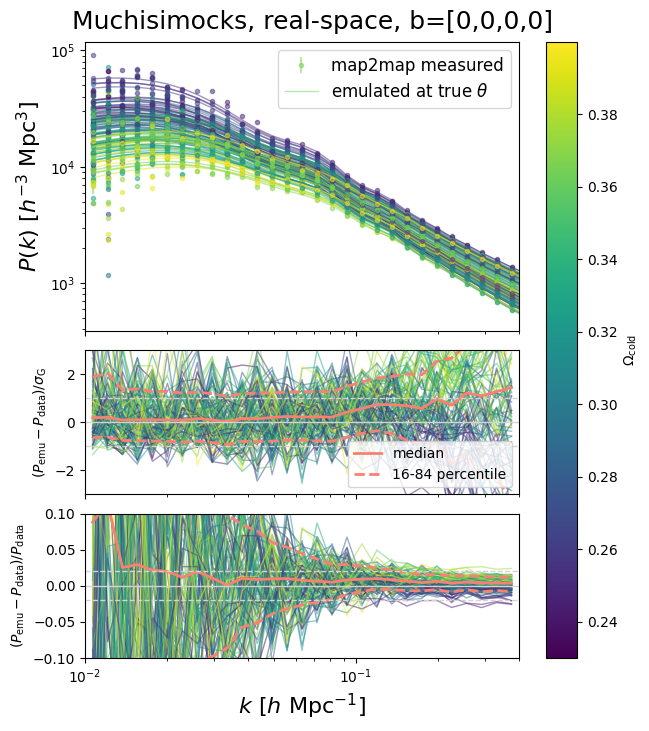

In [28]:
#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 3, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1, ax2 = axarr
    
    fig.suptitle(fr"Muchisimocks, real-space{title_tag}", y=0.92, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in i_plot:
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
        
        if first or show_error_all:
            axarr[0].errorbar(k, Pk[i], yerr=gaussian_error_pk[i], 
                            ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        else:
            axarr[0].plot(k, Pk[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        
        axarr[0].plot(k, Pk_emu[i], ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        axarr[1].plot(k, (Pk_emu[i]-Pk[i])/gaussian_error_pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (Pk_emu[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_emu - Pk
    diff_overG = diff_Pk/gaussian_error_pk
    diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    diff_overG_med = np.median(diff_overG, axis=0)

    diff_overPk = diff_Pk/Pk
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_overG_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_overG_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_overG_84, color='salmon', lw=2, ls='--')
    
    axarr[2].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    axarr[1].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    # axarr[1].fill_between(k, diff_overG_16, diff_overG_84, color='salmon', alpha=alpha_16_84,
    #                       zorder=10000,
    #                     label='16-84 percentile of training set')
    # axarr[2].fill_between(k, diff_overPk_16, diff_overPk_84, color='salmon', zorder=10000, alpha=alpha_16_84)
    # axarr[3].fill_between(k, ratio_16, ratio_84, color='salmon', zorder=10000, alpha=alpha_16_84)
           
    color_hline = 'lightgrey'
    axarr[1].axhline(0, color=color_hline, lw=1)
    axarr[2].axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-3, 3)
    axarr[2].set_ylim(-0.1, 0.1)
    #axarr[1].set_ylim(-10, 20)
    #axarr[2].set_ylim(-0.4, 0.4)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [1,0]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)

    axarr[1].legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=10)
    axarr[2].set_ylabel(r'$(P_\text{emu}-P_\text{data})/P_\text{data}$', fontsize=10)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks{tag_pk}.png', bbox_inches='tight')

/tmp/ipykernel_3333928/2544511407.py:46: RuntimeWarning: invalid value encountered in divide
  axarr[1].plot(k, (Pk_kaiserboosted[i]-Pk_zspace[i])/Pk_zspace[i], ls=':', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_3333928/2544511407.py:47: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/Pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_3333928/2544511407.py:57: RuntimeWarning: divide by zero encountered in divide
  diff_overPk = diff_Pk/Pk_zspace
/tmp/ipykernel_3333928/2544511407.py:67: RuntimeWarning: invalid value encountered in divide
  diff_overPk_realK = diff_Pk_realK/Pk_zspace


[<matplotlib.lines.Line2D object at 0x7f3e8055d4d0>, <matplotlib.lines.Line2D object at 0x7f3e8058c7d0>, <matplotlib.lines.Line2D object at 0x7f3e8058f2d0>, <matplotlib.lines.Line2D object at 0x7f3e8058f210>, <matplotlib.lines.Line2D object at 0x7f3e805903d0>, <matplotlib.lines.Line2D object at 0x7f3e80592f90>, <matplotlib.lines.Line2D object at 0x7f3e80590750>, <matplotlib.lines.Line2D object at 0x7f3e80558bd0>, <matplotlib.lines.Line2D object at 0x7f3e8055a3d0>, <matplotlib.lines.Line2D object at 0x7f3e8055b310>, <matplotlib.lines.Line2D object at 0x7f3e80581a90>, <matplotlib.lines.Line2D object at 0x7f3e805808d0>, <matplotlib.lines.Line2D object at 0x7f3e805839d0>, <matplotlib.lines.Line2D object at 0x7f3e80573f10>, <matplotlib.lines.Line2D object at 0x7f3e80570a50>, <matplotlib.lines.Line2D object at 0x7f3e805709d0>, <matplotlib.lines.Line2D object at 0x7f3e805ad7d0>, <matplotlib.lines.Line2D object at 0x7f3e805ad650>, <matplotlib.lines.Line2D object at 0x7f3e80550250>, <matplotlib

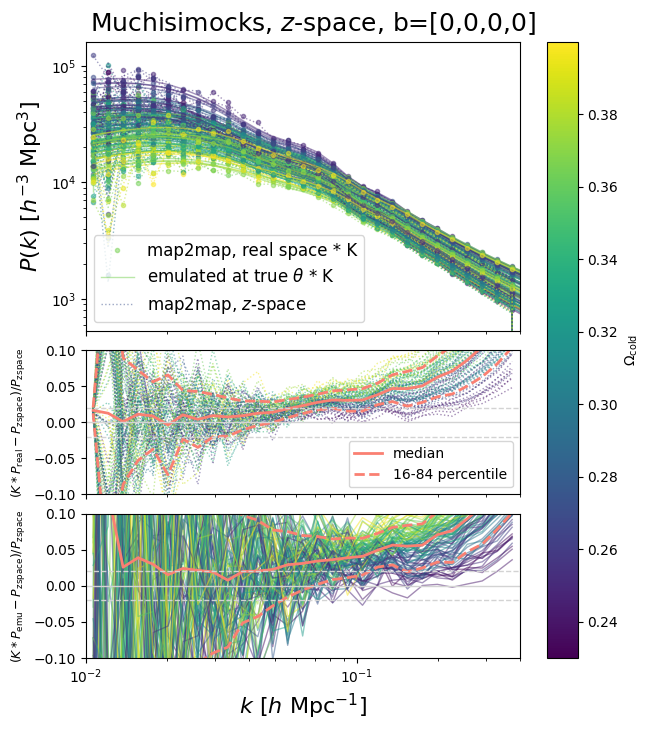

In [29]:
#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 3, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1, ax2 = axarr
    
    fig.suptitle(fr"Muchisimocks, $z$-space{title_tag}", y=0.92, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in i_plot:
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$ * K'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            label_real_kb = 'map2map, real space * K'
            label_zspace = r'map2map, $z$-space'
            
        if first or show_error_all:
            axarr[0].errorbar(k, Pk_zspace[i], yerr=gaussian_error_pk_zspace[i], 
                            #ls='None', marker='o', markersize=3, alpha=0.5, label=label_zspace, color=colors[i],
                            ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw
                            )
        else:
            #axarr[0].plot(k, Pk_zspace[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
            axarr[0].plot(k, Pk_zspace[i], ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw)

        axarr[0].plot(k, Pk_kaiserboosted[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_real_kb, color=colors[i])
        axarr[0].plot(k, Pk_emu_zspace[i], ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        #axarr[1].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/gaussian_error_pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[1].plot(k, (Pk_kaiserboosted[i]-Pk_zspace[i])/Pk_zspace[i], ls=':', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/Pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_emu_zspace - Pk_zspace
    # diff_overG = diff_Pk/gaussian_error_pk_zspace
    # diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    # diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    # diff_overG_med = np.median(diff_overG, axis=0)
    diff_overPk = diff_Pk/Pk_zspace
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)
    
    diff_Pk_realK = Pk_kaiserboosted - Pk_zspace
    # diff_overG = diff_Pk/gaussian_error_pk_zspace
    # diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    # diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    # diff_overG_med = np.median(diff_overG, axis=0)
    diff_overPk_realK = diff_Pk_realK/Pk_zspace
    diff_overPk_realK_16 = np.percentile(diff_overPk_realK, 16, axis=0)
    diff_overPk_realK_84 = np.percentile(diff_overPk_realK, 84, axis=0)
    diff_overPk_realK_med = np.median(diff_overPk_realK, axis=0)


    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_overPk_realK_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_overPk_realK_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_overPk_realK_84, color='salmon', lw=2, ls='--')
    
    axarr[2].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    axarr[1].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    # axarr[1].fill_between(k, diff_overG_16, diff_overG_84, color='salmon', alpha=alpha_16_84,
    #                       zorder=10000,
    #                     label='16-84 percentile of training set')
    # axarr[2].fill_between(k, diff_overPk_16, diff_overPk_84, color='salmon', zorder=10000, alpha=alpha_16_84)
    # axarr[3].fill_between(k, ratio_16, ratio_84, color='salmon', zorder=10000, alpha=alpha_16_84)
           
    color_hline = 'lightgrey'
    axarr[1].axhline(0, color=color_hline, lw=1)
    axarr[2].axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-0.1, 0.1)
    axarr[2].set_ylim(-0.1, 0.1)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [0,1,2]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)

    axarr[1].legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    #axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=10)
    axarr[1].set_ylabel(r'$(K*P_\text{real}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)
    axarr[2].set_ylabel(r'$(K*P_\text{emu}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks_zspace{tag_pk_zspace}.png', bbox_inches='tight')

/tmp/ipykernel_3333928/3427033232.py:45: RuntimeWarning: invalid value encountered in divide
  ax1.plot(k, (Pk_zspace[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_3333928/3427033232.py:52: RuntimeWarning: invalid value encountered in divide
  diff_overPk = diff_Pk/Pk


[<matplotlib.lines.Line2D object at 0x7f3ea8493dd0>, <matplotlib.lines.Line2D object at 0x7f3ea8490fd0>] ['map2map, real space', 'map2map, $z$-space']
[<matplotlib.lines.Line2D object at 0x7f3ea81e2510>, <matplotlib.lines.Line2D object at 0x7f3ea07bb6d0>] ['median', '16-84 percentile']


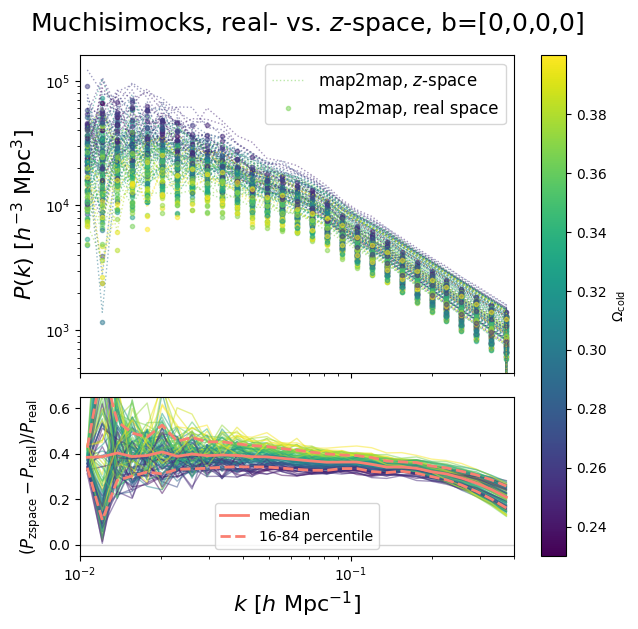

In [30]:
#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 2, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,6.5), sharex=True, height_ratios=[2,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1 = axarr
    
    fig.suptitle(fr"Muchisimocks, real- vs. $z$-space{title_tag}", y=0.95, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in i_plot:
        
        label_true, label_emu, label_stdev = None, None, None
        label_real, label_zspace = None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            label_real = 'map2map, real space'
            label_zspace = r'map2map, $z$-space'
        
        #axarr[0].plot(k, Pk[i], ls='--', alpha=0.5, label=label_real, color=colors[i], lw=lw)
        axarr[0].plot(k, Pk[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_real, color=colors[i])
        #axarr[0].plot(k, Pk_zspace[i], ls='None', marker='d', markersize=3, alpha=0.5, label=label_zspace, color=colors[i], markerfacecolor='None')
        axarr[0].plot(k, Pk_zspace[i], ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw)

        # if first or show_error_all:
        #     axarr[0].errorbar(k, Pk[i], yerr=gaussian_error_pk_zspace[i], 
        #                     ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        # else:
        #     axarr[0].plot(k, Pk_zspace[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        
        ax1.plot(k, (Pk_zspace[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_zspace - Pk

    diff_overPk = diff_Pk/Pk
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    alpha_16_84 = 0.5

    ax1.plot(k, diff_overPk_med, color='salmon', lw=2, label='median')
    ax1.plot(k, diff_overPk_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    ax1.plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    color_hline = 'lightgrey'
    ax1.axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-0.05, 0.65)
    #axarr[2].set_ylim(-0.1, 0.1)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [1,0]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)
    #axarr[1].legend(fontsize=10)

    ax1.legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    ax1.set_ylabel(r'$(P_\text{zspace}-P_\text{real})/P_\text{real}$', fontsize=12)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks_vszspace{tag_pk}.png', bbox_inches='tight')

# b1000

In [31]:
# order of saved cosmo param files
# param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
# param_names = ['omega_cold', 'sigma_8', 'h']
# param_names_fixed = [name for name in param_names_all if name not in param_names]
# idxs_param_names = [param_names_all.index(name) for name in param_names]

n_grid = 128
n_grid_orig = 512
box_size = 1000.0

#tag_params = '_p3_n500'
tag_params = '_p5_n10000'
tag_mocks = tag_params
tag_fields = '_deconvolved'
#dir_mocks = f'/cosmos_storage/cosmosims/muchisimocks_lib{tag_mocks}'
#dir_mocks = f'/data/kstoreyf/muchisimocks/muchisimocks_lib{tag_mocks}'
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib{tag_mocks}'

title_tag = ', b=[1,0,0,0]'
tag_pk = '_b1000'
tag_pk_zspace = '_b1000_zspace'
dir_pks = f'../data/pks_mlib/pks{tag_mocks}{tag_pk}'
dir_pks_zspace = f'../data/pks_mlib/pks{tag_mocks}{tag_pk_zspace}'
bias_params = np.loadtxt(f'{dir_pks}/bias_params.txt')

fn_params = f'{dir_mocks}/params_lh{tag_params}.txt'
fn_params_fixed = f'{dir_mocks}/params_fixed{tag_params}.txt'
params_df = pd.read_csv(fn_params, index_col=0)
param_dict_fixed = pd.read_csv(fn_params_fixed).loc[0].to_dict()


idxs_LH_all = np.array([idx_LH for idx_LH in params_df.index.values 
                        if os.path.exists(f"{dir_pks}/pk_{idx_LH}.npy")
                        and os.path.exists(f"{dir_pks_zspace}/pk_{idx_LH}.npy")])
idxs_LH_all = np.sort(idxs_LH_all)
idxs_LH = idxs_LH_all
idxs_LH = np.array(np.sort(idxs_LH))
n_lib = len(idxs_LH)

print(n_lib)

10000


In [32]:
n_plot = 100
rng = np.random.default_rng(42)
i_plot = rng.choice(np.arange(len(idxs_LH)), n_plot, replace=False)
i_plot = np.array(np.sort(i_plot))

### Load data 

In [33]:
theta = []
Pk = []
Pk_zspace = []
gaussian_error_pk = []
gaussian_error_pk_zspace = []

param_names = params_df.columns.to_list()

for idx_LH in idxs_LH:
    #fn_fields = f'{dir_mocks}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
    #fn_params = f'{dir_mocks}/LH{idx_LH}/cosmo_{idx_LH}.txt'
    fn_pk = f'{dir_pks}/pk_{idx_LH}.npy'
    fn_pk_zspace = f'{dir_pks_zspace}/pk_{idx_LH}.npy'
    
    pk_obj = np.load(fn_pk, allow_pickle=True).item()
    Pk.append(pk_obj['pk'])
    gaussian_error_pk.append(pk_obj['pk_gaussian_error'])
    
    pk_obj_zspace = np.load(fn_pk_zspace, allow_pickle=True).item()
    Pk_zspace.append(pk_obj_zspace['pk'])
    gaussian_error_pk_zspace.append(pk_obj_zspace['pk_gaussian_error'])
    
    param_dict = params_df.loc[idx_LH].to_dict()
    theta.append( np.array([param_dict[pn] for pn in param_names]) )

Pk = np.array(Pk)
Pk_zspace = np.array(Pk_zspace)
theta = np.array(theta)
gaussian_error_pk = np.array(gaussian_error_pk)

kk = pk_obj['k'] # all ks should be same so just grab one
print(len(kk))
print(Pk.shape)

30
(10000, 30)


In [34]:
Pk_emu = []
dir_pnns = f'../data/pnns_mlib/pnns{tag_mocks}'
for i, idx_LH in enumerate(idxs_LH):
    fn_pnn = f'{dir_pnns}/pnn_{idx_LH}.npy'
    pnn_dict = np.load(fn_pnn, allow_pickle=True).item()
    pnn = pnn_dict['pnn']
    pk_emu, _ = utils.pnn_to_pk(pnn, bias_params)
    Pk_emu.append(pk_emu)

In [35]:
tag_b1 = f'_b{int(bias_params[0])}'
fn_kaiser = f'{dir_mocks}/kaiser_boosts{tag_params}{tag_b1}.csv'
df_kaiser = pd.read_csv(fn_kaiser, index_col=0)
kaiser_boosts = [df_kaiser.loc[idx_LH, 'kaiser_boost'] for idx_LH in idxs_LH]

In [36]:
kaiser_boosts = np.array(kaiser_boosts)
Pk_emu_zspace = Pk_emu * kaiser_boosts[:, np.newaxis] 
Pk_kaiserboosted = Pk * kaiser_boosts[:, np.newaxis] 

## Plot

/tmp/ipykernel_3333928/70976760.py:39: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(k, (Pk_emu[i]-Pk[i])/gaussian_error_pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_3333928/70976760.py:40: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (Pk_emu[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_3333928/70976760.py:46: RuntimeWarning: divide by zero encountered in divide
  diff_overG = diff_Pk/gaussian_error_pk
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_3333928/70976760.py:51: RuntimeWarning: divide by zero encountered in divide
  diff_overPk = diff_Pk/Pk


[<matplotlib.lines.Line2D object at 0x7f3e885aedd0>, <ErrorbarContainer object of 3 artists>] ['emulated at true $\\theta$', 'map2map measured']
[<matplotlib.lines.Line2D object at 0x7f3e605f5110>, <matplotlib.lines.Line2D object at 0x7f3ea02cce50>] ['median', '16-84 percentile']


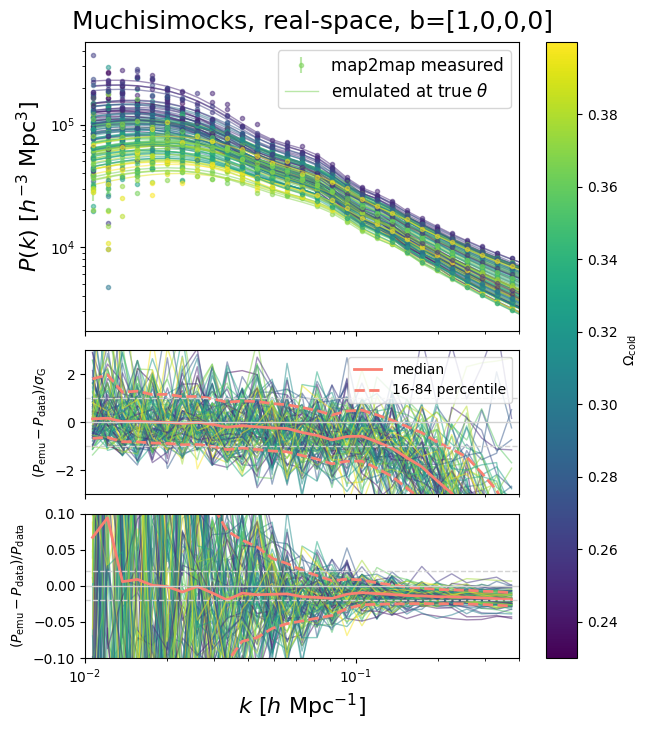

In [37]:
#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 3, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1, ax2 = axarr
    
    fig.suptitle(fr"Muchisimocks, real-space{title_tag}", y=0.92, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in i_plot:
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
        
        if first or show_error_all:
            axarr[0].errorbar(k, Pk[i], yerr=gaussian_error_pk[i], 
                            ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        else:
            axarr[0].plot(k, Pk[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        
        axarr[0].plot(k, Pk_emu[i], ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        axarr[1].plot(k, (Pk_emu[i]-Pk[i])/gaussian_error_pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (Pk_emu[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_emu - Pk
    diff_overG = diff_Pk/gaussian_error_pk
    diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    diff_overG_med = np.median(diff_overG, axis=0)

    diff_overPk = diff_Pk/Pk
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_overG_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_overG_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_overG_84, color='salmon', lw=2, ls='--')
    
    axarr[2].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    axarr[1].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    # axarr[1].fill_between(k, diff_overG_16, diff_overG_84, color='salmon', alpha=alpha_16_84,
    #                       zorder=10000,
    #                     label='16-84 percentile of training set')
    # axarr[2].fill_between(k, diff_overPk_16, diff_overPk_84, color='salmon', zorder=10000, alpha=alpha_16_84)
    # axarr[3].fill_between(k, ratio_16, ratio_84, color='salmon', zorder=10000, alpha=alpha_16_84)
           
    color_hline = 'lightgrey'
    axarr[1].axhline(0, color=color_hline, lw=1)
    axarr[2].axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-3, 3)
    axarr[2].set_ylim(-0.1, 0.1)
    #axarr[1].set_ylim(-10, 20)
    #axarr[2].set_ylim(-0.4, 0.4)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [1,0]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)

    axarr[1].legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=10)
    axarr[2].set_ylabel(r'$(P_\text{emu}-P_\text{data})/P_\text{data}$', fontsize=10)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks{tag_pk}.png', bbox_inches='tight')

/tmp/ipykernel_3333928/2544511407.py:46: RuntimeWarning: invalid value encountered in divide
  axarr[1].plot(k, (Pk_kaiserboosted[i]-Pk_zspace[i])/Pk_zspace[i], ls=':', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_3333928/2544511407.py:47: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/Pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_3333928/2544511407.py:57: RuntimeWarning: divide by zero encountered in divide
  diff_overPk = diff_Pk/Pk_zspace
/tmp/ipykernel_3333928/2544511407.py:67: RuntimeWarning: invalid value encountered in divide
  diff_overPk_realK = diff_Pk_realK/Pk_zspace


[<matplotlib.lines.Line2D object at 0x7f3ea0704490>, <matplotlib.lines.Line2D object at 0x7f3e8850af10>, <matplotlib.lines.Line2D object at 0x7f3ea865ed10>, <matplotlib.lines.Line2D object at 0x7f3ea865f190>, <matplotlib.lines.Line2D object at 0x7f3ea865e4d0>, <matplotlib.lines.Line2D object at 0x7f3eb0617d10>, <matplotlib.lines.Line2D object at 0x7f3ea81e4fd0>, <matplotlib.lines.Line2D object at 0x7f3ea81e5fd0>, <matplotlib.lines.Line2D object at 0x7f3ea07f5890>, <matplotlib.lines.Line2D object at 0x7f3ea07f49d0>, <matplotlib.lines.Line2D object at 0x7f3ea0752450>, <matplotlib.lines.Line2D object at 0x7f3ea07509d0>, <matplotlib.lines.Line2D object at 0x7f3ea0750b50>, <matplotlib.lines.Line2D object at 0x7f3ea0752dd0>, <matplotlib.lines.Line2D object at 0x7f3ea07b8a50>, <matplotlib.lines.Line2D object at 0x7f3ea07ba890>, <matplotlib.lines.Line2D object at 0x7f3ea8608cd0>, <matplotlib.lines.Line2D object at 0x7f3ea860ba10>, <matplotlib.lines.Line2D object at 0x7f3ea8608150>, <matplotlib

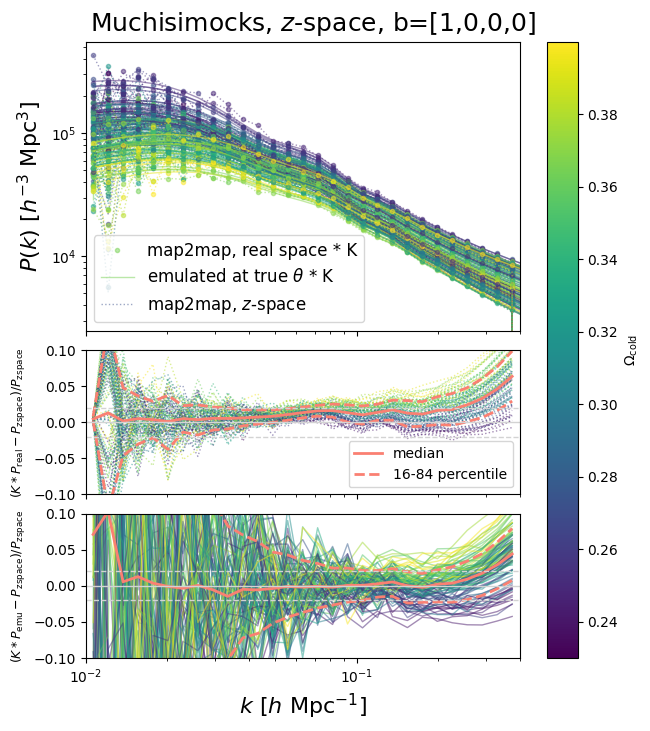

In [38]:
#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 3, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1, ax2 = axarr
    
    fig.suptitle(fr"Muchisimocks, $z$-space{title_tag}", y=0.92, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in i_plot:
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$ * K'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            label_real_kb = 'map2map, real space * K'
            label_zspace = r'map2map, $z$-space'
            
        if first or show_error_all:
            axarr[0].errorbar(k, Pk_zspace[i], yerr=gaussian_error_pk_zspace[i], 
                            #ls='None', marker='o', markersize=3, alpha=0.5, label=label_zspace, color=colors[i],
                            ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw
                            )
        else:
            #axarr[0].plot(k, Pk_zspace[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
            axarr[0].plot(k, Pk_zspace[i], ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw)

        axarr[0].plot(k, Pk_kaiserboosted[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_real_kb, color=colors[i])
        axarr[0].plot(k, Pk_emu_zspace[i], ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        #axarr[1].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/gaussian_error_pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[1].plot(k, (Pk_kaiserboosted[i]-Pk_zspace[i])/Pk_zspace[i], ls=':', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/Pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_emu_zspace - Pk_zspace
    # diff_overG = diff_Pk/gaussian_error_pk_zspace
    # diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    # diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    # diff_overG_med = np.median(diff_overG, axis=0)
    diff_overPk = diff_Pk/Pk_zspace
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)
    
    diff_Pk_realK = Pk_kaiserboosted - Pk_zspace
    # diff_overG = diff_Pk/gaussian_error_pk_zspace
    # diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    # diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    # diff_overG_med = np.median(diff_overG, axis=0)
    diff_overPk_realK = diff_Pk_realK/Pk_zspace
    diff_overPk_realK_16 = np.percentile(diff_overPk_realK, 16, axis=0)
    diff_overPk_realK_84 = np.percentile(diff_overPk_realK, 84, axis=0)
    diff_overPk_realK_med = np.median(diff_overPk_realK, axis=0)


    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_overPk_realK_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_overPk_realK_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_overPk_realK_84, color='salmon', lw=2, ls='--')
    
    axarr[2].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    axarr[1].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    # axarr[1].fill_between(k, diff_overG_16, diff_overG_84, color='salmon', alpha=alpha_16_84,
    #                       zorder=10000,
    #                     label='16-84 percentile of training set')
    # axarr[2].fill_between(k, diff_overPk_16, diff_overPk_84, color='salmon', zorder=10000, alpha=alpha_16_84)
    # axarr[3].fill_between(k, ratio_16, ratio_84, color='salmon', zorder=10000, alpha=alpha_16_84)
           
    color_hline = 'lightgrey'
    axarr[1].axhline(0, color=color_hline, lw=1)
    axarr[2].axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-0.1, 0.1)
    axarr[2].set_ylim(-0.1, 0.1)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [0,1,2]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)

    axarr[1].legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    #axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=10)
    axarr[1].set_ylabel(r'$(K*P_\text{real}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)
    axarr[2].set_ylabel(r'$(K*P_\text{emu}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks_zspace{tag_pk_zspace}.png', bbox_inches='tight')

/tmp/ipykernel_3333928/3427033232.py:45: RuntimeWarning: invalid value encountered in divide
  ax1.plot(k, (Pk_zspace[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_3333928/3427033232.py:52: RuntimeWarning: invalid value encountered in divide
  diff_overPk = diff_Pk/Pk


[<matplotlib.lines.Line2D object at 0x7f3ea82835d0>, <matplotlib.lines.Line2D object at 0x7f3ea8283610>] ['map2map, real space', 'map2map, $z$-space']
[<matplotlib.lines.Line2D object at 0x7f3ea05f0c90>, <matplotlib.lines.Line2D object at 0x7f3e80432550>] ['median', '16-84 percentile']


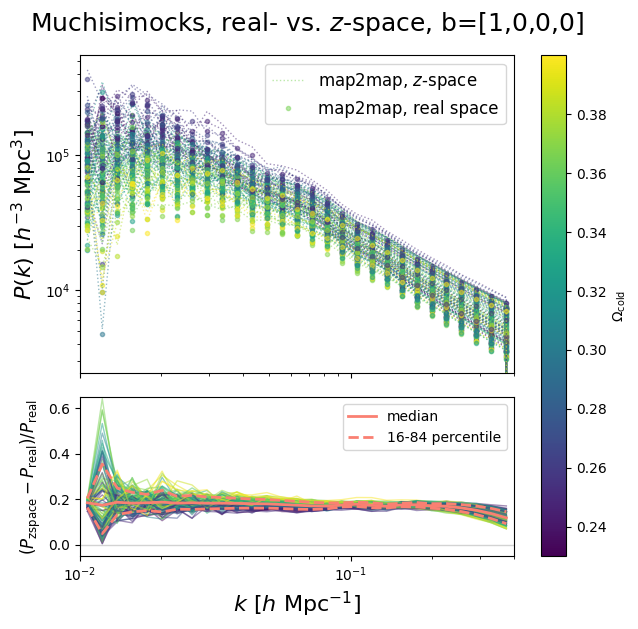

In [39]:
#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 2, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,6.5), sharex=True, height_ratios=[2,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1 = axarr
    
    fig.suptitle(fr"Muchisimocks, real- vs. $z$-space{title_tag}", y=0.95, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in i_plot:
        
        label_true, label_emu, label_stdev = None, None, None
        label_real, label_zspace = None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            label_real = 'map2map, real space'
            label_zspace = r'map2map, $z$-space'
        
        #axarr[0].plot(k, Pk[i], ls='--', alpha=0.5, label=label_real, color=colors[i], lw=lw)
        axarr[0].plot(k, Pk[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_real, color=colors[i])
        #axarr[0].plot(k, Pk_zspace[i], ls='None', marker='d', markersize=3, alpha=0.5, label=label_zspace, color=colors[i], markerfacecolor='None')
        axarr[0].plot(k, Pk_zspace[i], ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw)

        # if first or show_error_all:
        #     axarr[0].errorbar(k, Pk[i], yerr=gaussian_error_pk_zspace[i], 
        #                     ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        # else:
        #     axarr[0].plot(k, Pk_zspace[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        
        ax1.plot(k, (Pk_zspace[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_zspace - Pk

    diff_overPk = diff_Pk/Pk
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    alpha_16_84 = 0.5

    ax1.plot(k, diff_overPk_med, color='salmon', lw=2, label='median')
    ax1.plot(k, diff_overPk_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    ax1.plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    color_hline = 'lightgrey'
    ax1.axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-0.05, 0.65)
    #axarr[2].set_ylim(-0.1, 0.1)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [1,0]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)
    #axarr[1].legend(fontsize=10)

    ax1.legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    ax1.set_ylabel(r'$(P_\text{zspace}-P_\text{real})/P_\text{real}$', fontsize=12)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks_vszspace{tag_pk}.png', bbox_inches='tight')